# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:

pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as ny
import seaborn as sb 

# чтение csv-файла с данными статистика /datasets/real_estate_data.csv в DataFrame и сохранение в  переменную "data"
#обратим внимание что разделителем в файле будет '\t'
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')


In [4]:
# Отображение всех колонок при выводе на печать
pd.set_option('display.max_columns', None)

In [5]:
# 2) посмотрим типы данных и кол-во ненулевых значений, определим некорректное ли именование столбцов.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Итак, из общей информации видим:
1. В названиях колонок нарушения хорошего стиля **не наблюдается*

2. В таблице 22 столбца. Согласно описанию данных:
* *0 :* `total_images` — число фотографий квартиры в объявлении
* *1 :* `last_price` — цена на момент снятия с публикации
* *2 :* `total_area` — общая площадь квартиры в квадратных метрах (м²)
* *3 :* `first_day_exposition` — дата публикации
* *4 :* `rooms` — число комнат
* *5 :* `ceiling_height` — высота потолков (м)
* *6 :* `floors_total` — всего этажей в доме
* *7 :* `living_area` — жилая площадь в квадратных метрах (м²)
* *8 :* `floor` — этаж
* *9 :* `is_apartment` — апартаменты (булев тип)
* *10:* `studio` — квартира-студия (булев тип)
* *11:* `open_plan` — свободная планировка (булев тип)
* *12:* `kitchen_area` — площадь кухни в квадратных метрах (м²)
* *13:* `balcony` — число балконов
* *14:* `locality_name` — название населённого пункта
* *15:* `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
* *16:* `cityCenters_nearest` — расстояние до центра города (м)
* *17:* `parks_around3000` — число парков в радиусе 3 км
* *18:* `parks_nearest` — расстояние до ближайшего парка (м)
* *19:* `ponds_around3000` — число водоёмов в радиусе 3 км
* *20:* `ponds_nearest` — расстояние до ближайшего водоёма (м)
* *22:* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)


3. Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

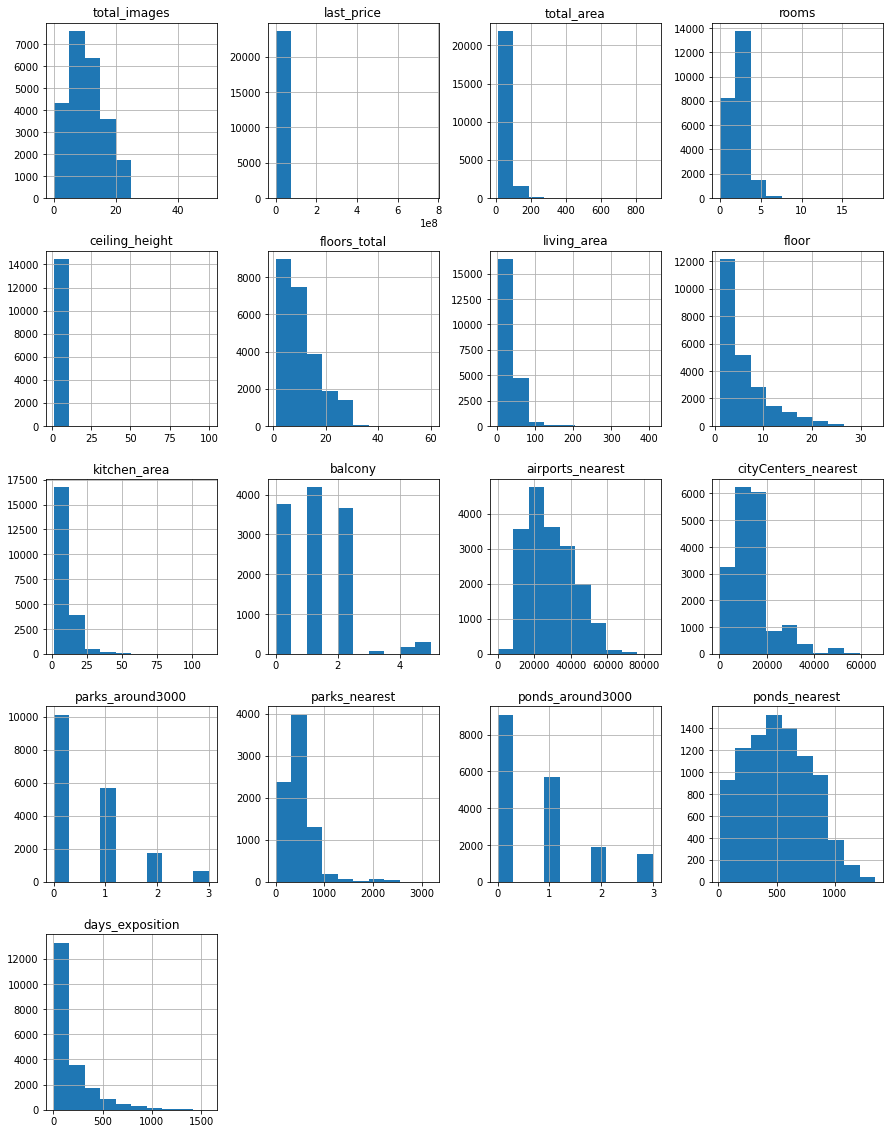

In [6]:
# Построим гистограмму для всех числовых столбцов таблицы на одном графике. 
data.hist(figsize=(15, 20))
plt.show()

**Выводы:**
В каждой строке таблицы — данные об единичном продаваемом объекте недвижимости. Предварительно можно утверждать, что данных достаточно для проведения анализа. 
Из описания dataset следует, что по каждой квартире на продажу доступны два вида данных:
1. Первые вписаны пользователем,
2. Вторые — получены автоматически  без участия пользователя на основе картографических данных:
    * `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
    * `cityCenters_nearest` — расстояние до центра города (м)
    * `parks_around3000` — число парков в радиусе 3 км
    * `parks_nearest` — расстояние до ближайшего парка (м)
    * `ponds_around3000` — число водоёмов в радиусе 3 км
    * `ponds_nearest` — расстояние до ближайшего водоёма (м)


При ознакомлении с общей информацией заметили следующее явные нарушения:
1. `first_day_exposition` - object - должен быть тип datetime
2. `ceiling_height` - пустые значения
3. `floors_total` - должен быть тип int, т.к. количество этажей - целое значение + пустые значения
4. `is_apartment` - должен быть тип bool + пустые значения
5. `living_area` - пустые значения
6. `kitchen_area` - пустые значения
7. `balcony` - пустые значения
8. `locality_name`  - пустые значения
9. `airports_nearest` - пустые значения
10. `cityCenters_nearest` - пустые значения
11. `parks_around3000` - тип должен быть int + пустые значения
12. `parks_nearest`  - пустые значения
13. `ponds_around3000` - тип должен быть int + пустые значения
14. `ponds_nearest` - пустые значения
15. `days_exposition` - тип должен быть int + пустые значения 

В связи с этим возникает необходимость проведения предподготовки данных к анализу.

### Шаг 2. Выполните предобработку данных

In [7]:
# Выведем на экран названия столбцов
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [8]:
# Проведем ознакомления с полученными данными,  для выявления нестандартных значений на первый взгляд и ошибок, 
# посмотрим на первые 10 строк таблицы data
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


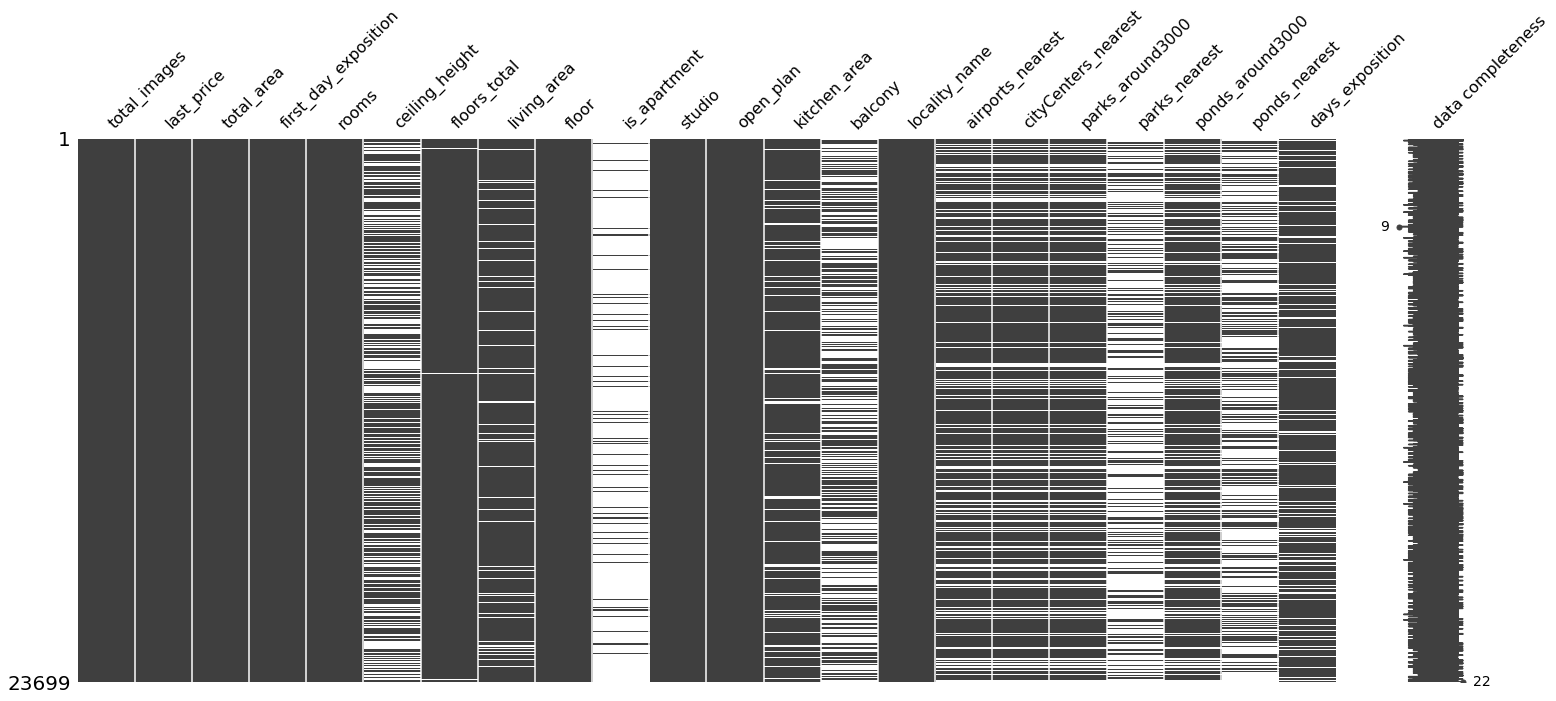

In [9]:
# посмотрим на пропуски
msno.matrix(data, labels=True)
plt.show()

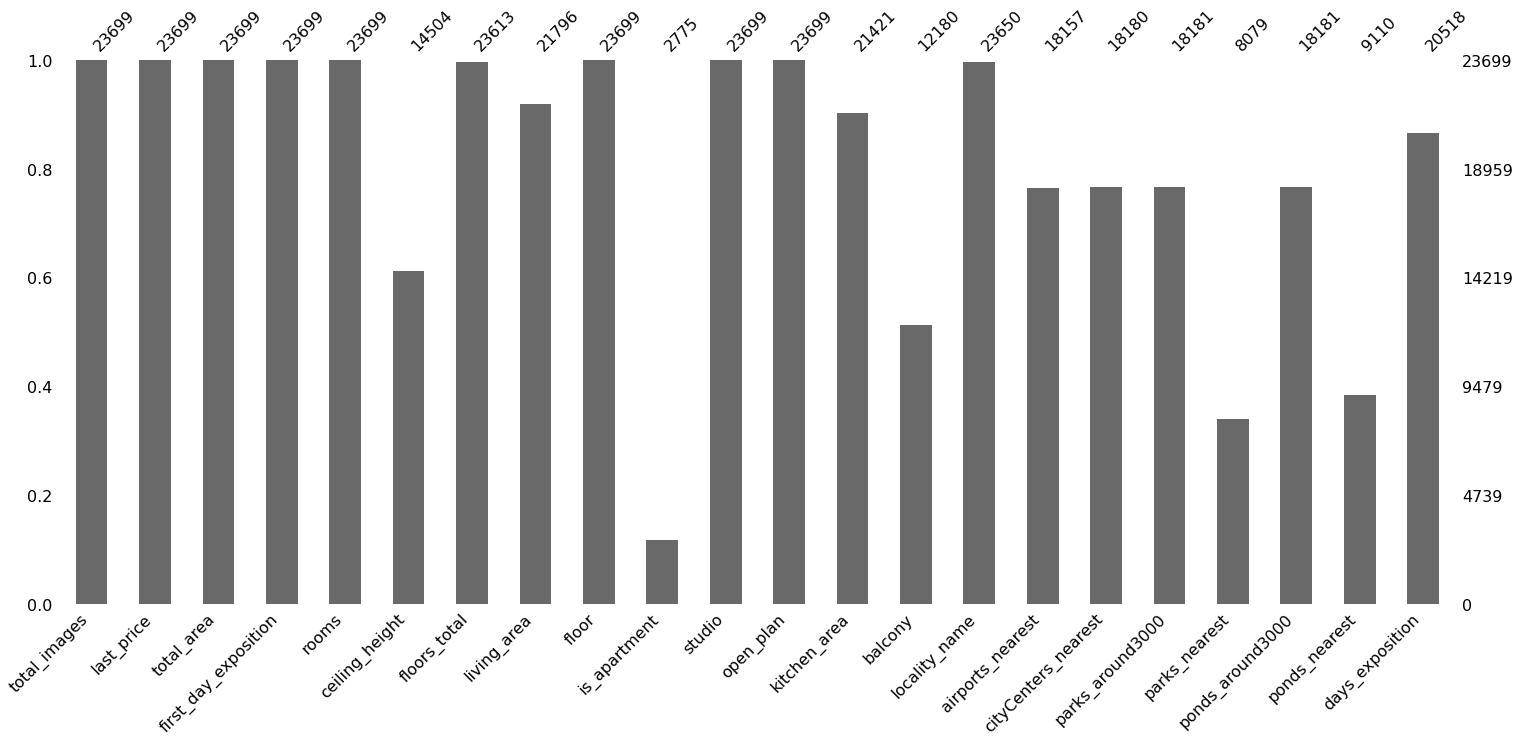

In [10]:
msno.bar(data)
plt.show()

Оставляем без изменений столбцы следующих групп пропусков:
1. *замечаний не выявлено*
    * `total_images` - число фотографий квартиры в объявлении
    * `floor` - этаж
    * `rooms` - число комнат
    * `total_area` - общая площадь квартиры в квадратных метрах (м²)
    
2. *Пользовательские данные, в которых присутствуют Неслучайные пропуски, по причине, что некоторые пользователи не предоставили информацию. Данные пропуски не подлежат замене и будут обрабатываться путем удаления строк перед проведениям анализа данных  для  следующих столбцов:
    * `ceiling_height` - высота потолков (м)
    * `is_apartment` - апартаменты (булев тип)

2. *Автоматические данные, в которых присутствуют Неслучайные пропуски, по причине, отсутствия  картографической информации. Данные пропуски не подлежат замене и будут обрабатываться путем удаления строк перед проведениям анализа данных для следующих столбцов:
    * `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
    * `cityCenters_nearest` — расстояние до центра города (м)
    * `parks_around3000` — число парков в радиусе 3 км
    * `parks_nearest` — расстояние до ближайшего парка (м)
    * `ponds_around3000` — число водоёмов в радиусе 3 км

In [11]:
#посмотрим значения в  данных столбцах
list_columns = ['total_images', 'ceiling_height', 'floor', 'is_apartment', 'total_area', 
                'rooms', 'airports_nearest', 'airports_nearest', 'cityCenters_nearest',
               'parks_around3000','parks_nearest', 'ponds_around3000']

for col in list_columns:
    print(f'------ Количество уникальных значений в столбце: {col} --------')
    print(data[col].value_counts())
    print()

------ Количество уникальных значений в столбце: total_images --------
10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
13    1015
4      986
14     986
15     948
1      872
3      769
16     761
17     650
18     642
2      640
19     603
23      16
21      12
24       8
22       8
26       5
28       4
32       4
29       3
50       3
27       2
35       2
30       2
31       2
39       1
25       1
42       1
37       1
Name: total_images, dtype: int64

------ Количество уникальных значений в столбце: ceiling_height --------
2.50     3515
2.60     1646
2.70     1574
3.00     1112
2.80      993
         ... 
4.25        1
3.39        1
3.93        1
10.30       1
4.65        1
Name: ceiling_height, Length: 183, dtype: int64

------ Количество уникальных значений в столбце: floor --------
2     3368
3     3073
1     2917
4     2804
5     2621
6     1305
7     1218
8     1083
9     1051
10     687
12     526
11     523
13   

In [12]:
#Оптимально дни никак не заметить и лучше всего подставить заглушку 
#заменим пропуски в days_exposition и заменим тип данных
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121


In [13]:
#пропущенные значения в locality_name не будем трогать, т.к. причина их отсутствия не понятна
data['locality_name'].value_counts()

Санкт-Петербург       15721
посёлок Мурино          522
посёлок Шушары          440
Всеволожск              398
Пушкин                  369
                      ...  
поселок Гладкое           1
деревня Щеглово           1
посёлок Плоское           1
деревня Новолисино        1
деревня Лупполово         1
Name: locality_name, Length: 364, dtype: int64

In [14]:
#переведем столбец с датой в формат даты без времени, т.к. время не указано
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121


In [15]:
#Раз есть пропуски в балконах, то их просто могло и не быть
#заменим пропуски в balcony на 0 и изменим тип данных на int
data['balcony'] = data['balcony'].fillna(0).astype('int')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
18545,6,3750000.0,43.0,2019-03-18,2,25.0,5.0,29.0,3,False,False,False,NaN,0,Санкт-Петербург,27054.0,8033.0,1.0,540.0,0.0,NaN,12
355,17,3600000.0,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,False,False,NaN,2,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259
6246,6,3300000.0,44.4,2019-03-25,2,25.0,5.0,31.3,5,NaN,False,False,5.7,0,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,0
14382,9,1700000.0,35.0,2015-12-04,1,25.0,5.0,20.0,2,False,False,False,8.0,1,поселок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,206
11285,0,1950000.0,37.0,2019-03-20,1,25.0,5.0,17.0,4,False,False,False,9.0,2,Луга,NaN,NaN,NaN,NaN,NaN,NaN,18
4643,0,4300000.0,45.0,2018-02-01,2,25.0,9.0,30.0,2,NaN,False,False,7.0,1,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181
9379,5,3950000.0,42.0,2017-03-26,3,25.0,5.0,30.0,2,NaN,False,False,5.2,0,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,0
5669,4,4400000.0,50.0,2017-08-08,2,26.0,9.0,21.3,3,NaN,False,False,7.0,2,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267
5807,17,8150000.0,80.0,2019-01-09,2,27.0,36.0,41.0,13,NaN,False,False,12.0,5,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38
5246,0,2500000.0,54.0,2017-10-13,2,27.0,5.0,30.0,3,NaN,False,False,9.0,2,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540


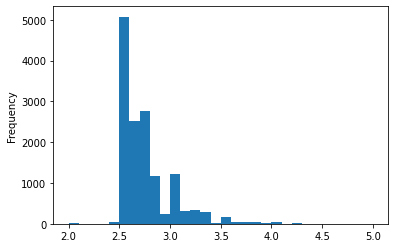

In [16]:
#посмотрим параметр ceiling_height, видим что есть необоснованно большие значения но пока оставим их как есть,
#медиана от среднего отличается не сильно из-за этих выбросов во всей выборке
data['ceiling_height'].sort_values().plot(y = 'ceiling_height', kind = 'hist', bins = 30, range=(2,5))
data['ceiling_height'].value_counts()
data['ceiling_height'].describe()
data[data['ceiling_height'] > 4].sort_values('ceiling_height').tail(20)

In [17]:
#столбец апартаменты видимо появился не вместе с началом ведения записей, все пропущенные значения заменим на False, 
#апартаменты появились относительно недавно
data['is_apartment'] = data['is_apartment'].fillna(False)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121


In [18]:
#изменим цену на тип int для удобства просмотра
data['last_price'] = data['last_price'].astype('int')
data['last_price'].sort_values(ascending=False)

12971    763000000
19540    420000000
14706    401300000
1436     330000000
15651    300000000
           ...    
16219       450000
16274       440000
17456       430000
14911       430000
8793         12190
Name: last_price, Length: 23699, dtype: int64

In [19]:
#посмотрим данные с пропущенными значениями в floors_total- ничего общего между ними нет, оставим как есть
data[data['floors_total'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000,65.2,2018-10-02,2,NaN,NaN,30.80,4,False,False,False,12.00,0,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49
237,4,2438033,28.1,2016-11-23,1,NaN,NaN,20.75,1,False,False,False,NaN,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251
457,4,9788348,70.8,2015-08-01,2,NaN,NaN,38.40,12,False,False,False,10.63,0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727
671,4,6051191,93.6,2017-04-06,3,NaN,NaN,47.10,8,False,False,False,16.80,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123
1757,5,3600000,39.0,2017-04-22,1,NaN,NaN,NaN,9,False,False,False,NaN,0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000,63.5,2017-05-24,2,2.8,NaN,NaN,3,False,False,False,NaN,0,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512
22656,4,4574160,64.5,2017-04-02,2,NaN,NaN,31.70,20,False,False,False,14.40,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127
22808,0,14569263,110.4,2016-11-20,3,NaN,NaN,45.38,6,False,False,False,23.42,0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260
23590,0,21187872,123.3,2017-04-25,3,NaN,NaN,50.40,18,False,False,False,23.60,0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104


In [20]:
#living_area слишком много знаков после запятой и есть пропущенные значения, 
#можно посчитать средний процент жилой площади от всей площади по всей выборке
#и высчитать для строк с пропусками жилую площадь как вариант но мы не будем тратить на это время
data['living_area'].value_counts()
data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [21]:
# Изучите уникальные значения в столбце с названиями
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [22]:
data['locality_name'].nunique()

364

В столбце 'locality_name' 364  уникальные записи. 

* Приводим всё к нижнему регистру

* Заменяем все "ё" на "е"

* Заменяем "городской поселок" на "поселок городского типа"

* Проверяем наличие явных дубликатов

In [23]:
#приводим всё к нижнему регистру
data['locality_name'] = data['locality_name'].str.lower()

In [24]:
# Избавимся от явных дубликатов заменим во всех словах букву "ё"  на букву "е"
data['locality_name'] = data['locality_name'].str.replace('ё', 'е') 

In [25]:
# заменяем "городской поселок" на "поселок городского типа"

data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
data['locality_name'].nunique()

323

В столбце 'locality_name' 323  уникальные записи. Мы избавились от дубликатов.

**Вывод**
В предоставленнной таблице данных имелись явные нарушения качества данных:
•    дублирование значений в столбце `locality_name`;
•    отсутствующие значения.
      
В связи с этим возникла необходимость проведения предподготовки данных к анализу.

### Шаг 3. Добавьте в таблицу новые столбцы

* цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой);
* день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
* месяц публикации объявления;
* год публикации объявления;
* тип этажа квартиры (значения — «‎первый», «последний», «другой»);
* расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).

In [26]:
#посчитаем цену квадратного метра
data['price_per_square_meter'] = data['last_price'] / data['total_area']
data['price_per_square_meter'].head()

0    120370.370370
1     82920.792079
2     92785.714286
3    408176.100629
4    100000.000000
Name: price_per_square_meter, dtype: float64

In [27]:
#для удобства просмотра  округлим до двух знаков после запятой
data['price_per_square_meter'] = data['price_per_square_meter'].round(2)
data['price_per_square_meter'].head()

0    120370.37
1     82920.79
2     92785.71
3    408176.10
4    100000.00
Name: price_per_square_meter, dtype: float64

In [28]:
#создаtv столбец дня недели публикации объявления 
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
data['weekday_exposition'].head()

0    3
1    1
2    3
3    4
4    1
Name: weekday_exposition, dtype: int64

In [29]:
#создаю столбец месяца публикации объявления 
data['month_exposition'] = data['first_day_exposition'].dt.month
data['month_exposition'].head()

0     3
1    12
2     8
3     7
4     6
Name: month_exposition, dtype: int64

In [30]:
#создаю столбец года публикации объявления 
data['year_exposition'] = data['first_day_exposition'].dt.year
data['year_exposition'].head()

0    2019
1    2018
2    2015
3    2015
4    2018
Name: year_exposition, dtype: int64

In [31]:
#напишем функцию категоризации по этажам, используя метод apply применимо к каждой строке датафрейма через axis = 1
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
    
#категоризуем этажи с помощью функции  
data['floor_category'] = data.apply(floor_category, axis = 1)
data['floor_category'].unique()

array(['другой', 'первый', 'последний'], dtype=object)

In [32]:
#добавим столбец расстояние до центра города в километрах и округлите до ближайших целых значений
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] / 1000
data['cityCenters_nearest_km'] = data.query('cityCenters_nearest_km >= 0')['cityCenters_nearest_km'].round(0).astype('int')
data['cityCenters_nearest_km'].head()

0    16.0
1    19.0
2    14.0
3     7.0
4     8.0
Name: cityCenters_nearest_km, dtype: float64

### Шаг 4. Проведите исследовательский анализ данных

#### Устранение выбросов

In [33]:
# Посмотрим на распределение значений в данных
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,cityCenters_nearest_km
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,18180.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,156.608844,9.942166e+04,2.569307,6.400101,2017.367146,14.184818
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,213.546873,5.030680e+04,1.789082,3.491561,1.039771,8.616194
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,0.000000,1.118300e+02,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,22.000000,7.658547e+04,1.000000,3.000000,2017.000000,9.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,74.000000,9.500000e+04,3.000000,6.000000,2017.000000,13.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,199.000000,1.142563e+05,4.000000,10.000000,2018.000000,16.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.907500e+06,6.000000,12.000000,2019.000000,66.000000


`total_images` - выглядит хорошо, оставляем

`last_price` - взглянем на квартиры от 0 до 20 млн, нет квартир стоимостью 0.

In [34]:
print('Квартир стоимостью 0:', data.query('last_price == 0')['last_price'].count())
print('Квартир стоимостью меньше 100.000:', data.query('last_price < 1e+05')['last_price'].count())
print('Квартир стоимостью больше 100.000.000:', data.query('last_price > 1e+08')['last_price'].count())

Квартир стоимостью 0: 0
Квартир стоимостью меньше 100.000: 1
Квартир стоимостью больше 100.000.000: 37


Есть одна квартира стоимостью меньше 100 000, её мы учитывать не будем.
225 квартир стоимостью меньше 1млн - не похоже на выброс, оставляем.

Убираем слишком дорогие квартиры стоимостью больше 100.000.000.

In [35]:
data.drop(index=data.query('last_price > 1e+08').index,inplace=True)
print('Квартир стоимостью больше 100.000.000:', data.query('last_price > 1e+08')['last_price'].count())


Квартир стоимостью больше 100.000.000: 0


In [36]:
# удалим квартиры стоимостью менее 100000
data.drop(index=data.query('last_price < 1e+05').index,inplace=True)

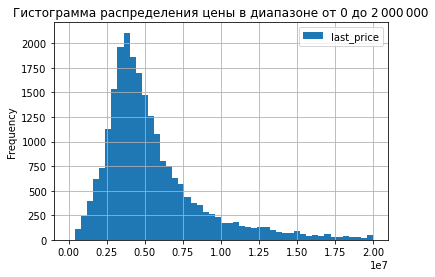

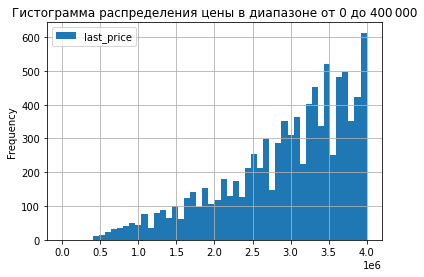

In [37]:
data.plot(y = 'last_price', kind = 'hist', grid=True, bins=50, range=(0,2e+07), title="Гистограмма распределения цены в диапазоне от 0 до 2 000 000")
data.plot(y = 'last_price', kind = 'hist', grid=True, bins=50, range=(0,4e+06), title="Гистограмма распределения цены в диапазоне от 0 до 400 000")
plt.show()

`total_area` - нет квартир площадью меньше 10 кв.м., но есть меньше 20.
Это не похоже на аномалию, к сожалению.

In [38]:
print('Квартир площадью менее 10 кв.м.:',data.query('total_area < 10')['total_area'].count()) 
print('Квартир площадью более 500 кв.м.:',data.query('total_area > 500')['total_area'].count())

Квартир площадью менее 10 кв.м.: 0
Квартир площадью более 500 кв.м.: 3


Квартиры со слишком большой площадью более 500 кв.м. похожи на элитную недвижимость, их немного и лучше удалить.

In [39]:
#Удаление элитных квартир с больщой площадью
data.drop(index=data.query('total_area > 500').index,inplace=True)

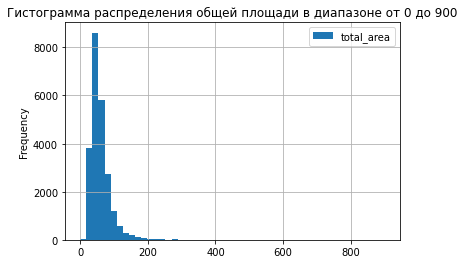

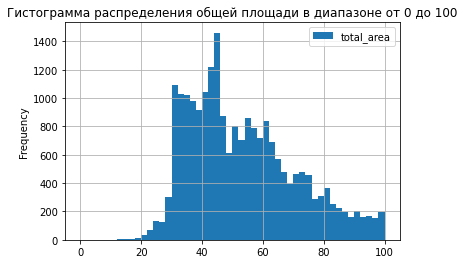

In [40]:
#data.hist('total_area', bins=50, range=(0,900));
#data.hist('total_area', bins=50, range=(0,100));
data.plot(y = 'total_area', kind = 'hist', bins=50,grid=True,  range=(0,900), title="Гистограмма распределения общей площади в диапазоне от 0 до 900")
data.plot(y = 'total_area', kind = 'hist', bins=50,grid=True,  range=(0,100), title="Гистограмма распределения общей площади в диапазоне от 0 до 100")
plt.show()

`rooms` - есть нулевые значения, 195.
Не будем торопится, проверим, может это студии, апартаменты или свободная планировка?

In [41]:
print('Квартиры без комнат:',data.query('rooms == 0')['rooms'].count())

print('Квартиры без комнат и студии:',data.query('rooms == 0 and studio')['rooms'].count()) 

print('Квартиры без комнат и апартаменты:',data.query('rooms == 0 and is_apartment')['rooms'].count()) 

print('Квартиры без комнат и свободная планировка:',data.query('rooms == 0 and open_plan')['rooms'].count())

print('Квартиры без комнат не апартаменты и не свободная планировка:',data.query('rooms == 0 and ~open_plan and ~studio')['rooms'].count())

data.drop(index=data.query('rooms > 7').index,inplace=True)

Квартиры без комнат: 197
Квартиры без комнат и студии: 138
Квартиры без комнат и апартаменты: 0
Квартиры без комнат и свободная планировка: 59
Квартиры без комнат не апартаменты и не свободная планировка: 0


Похоже так и есть.
Квартиры без комнат не апартаменты и не свободная планировка - 0.
Максимальное значение аж 19 комнат, но такое тоже бывает.

`ceiling_height` - высота потолков.
В жилых домах устанавливается с учетом минимальных требований, установленных СНиПом и комфортного пребывания в нем.
Независимо от года постройки и от типа здания, высота от пола до потолка должна быть в пределах 2,5-3,2 метров.

In [42]:
print('Квартир с потолками от 4 до 5м: ' + str(data.query('ceiling_height > 4 and ceiling_height <= 5')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 5 до 25м: ' + str(data.query('ceiling_height > 5 and ceiling_height < 25')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 25м до 36м: ' + str(data.query('ceiling_height >= 25 and ceiling_height <= 36')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 25м до 36м: ' + str(data.query('ceiling_height > 36 and ceiling_height < 50')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 50м: ' + str(data.query('ceiling_height >= 50')['ceiling_height'].count()) + ' шт.')

Квартир с потолками от 4 до 5м: 36 шт.
Квартир с потолками от 5 до 25м: 14 шт.
Квартир с потолками от 25м до 36м: 19 шт.
Квартир с потолками от 25м до 36м: 0 шт.
Квартир с потолками от 50м: 1 шт.


При изучении недвижимости известны только небольшое количество сверхдорогих двухэтажнх пентхаусов с высотой потолков 4-5м.
Можно предположить, что квартиры с высотой потолков 25-36м на самом деле являются опечаткой и соотвествуют 2.5-3.6м
Исходя их этого предполагаем, что все квартиры с высотой потолков от 36м являются выбросами.
Более того есть одно значение, которое показывает высоту потолков выше 50м.

In [43]:
#Удаляем квартиры с высотой потолков от 4 до 25метров.
data.drop(index=data.query('ceiling_height > 4 and ceiling_height < 25').index,inplace=True)

#Для квартир с высотой потолков до 25 до 36 метров предполагаем, что это опечатка и делим на 10, получая 2.5 и 3.6 метра.

data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 36)]['ceiling_height']/10)

#Удаляем квартиры с высотой потолков от 36 метров.
data.drop(index=data.query('ceiling_height > 36').index,inplace=True)

Смотрим на высоту полтолков менее 2.5м более пристально.

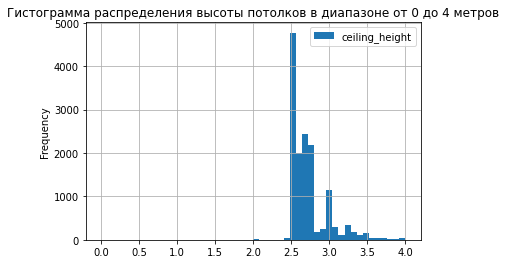

In [44]:
#data.hist('ceiling_height',bins=50,range=(0,4));

data.plot(y = 'ceiling_height', kind = 'hist', bins=50, range=(0,4),grid=True,  title="Гистограмма распределения высоты потолков в диапазоне от 0 до 4 метров")
plt.show()

In [45]:
print('Квартир с потолками меньше 2.5м : ' + str(data.query('ceiling_height < 2.5')['ceiling_height'].count()) + ' шт.')

Квартир с потолками меньше 2.5м : 73 шт.


Нас не интересуют квартиры с высотой потолков менее 2.5м, это не по СНиПу. Удаляем из выборки.

In [46]:
data.drop(index=data.query('ceiling_height < 2.5').index,inplace=True)

`floors_total` - всего этажей в доме

In [47]:
print('Квартир в одноэтажных домах : ',data.query('floors_total == 1')['floors_total'].count())
print('Квартир в 30+ этажных домах : ',data.query('floors_total > 30')['floors_total'].count())

Квартир в одноэтажных домах :  23
Квартир в 30+ этажных домах :  31


Есть одноэтажные квартиры,но это не похоже на выброс. Так же есть небольшое количество квартир в 30 и более этажных домах.

In [48]:
# Удалим квартиры у которых более 30 этажей
data.drop(index=data.query('floors_total > 30').index,inplace=True)

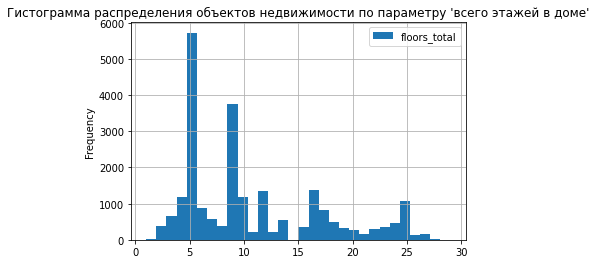

In [49]:
#data.hist('floors_total', bins=30);
data.plot(y = 'floors_total', kind = 'hist', bins=30, grid=True,  title="Гистограмма распределения объектов недвижимости по параметру 'всего этажей в доме'")
plt.show()

`living_area` - Имеем большое количество квартир с жилой площадью от 10 до 60 кв.м.

In [50]:
print('Жилая площадь меньше 10 кв.м.: ',data.query('living_area < 10')['living_area'].count())
print('Жилая площадь больше общей: ',data.query('living_area > total_area')['living_area'].count())
print('Жилая площадь больше 200: ',data.query('living_area > 200')['living_area'].count())

Жилая площадь меньше 10 кв.м.:  25
Жилая площадь больше общей:  0
Жилая площадь больше 200:  12


Здесь интерсуют квартиры с жилой площадью меньше 10 кв.м. их 25!
Судя по гистограмме есть даже с с жилой площадью 2 кв.м.
Ну это прям что-то странное, скорее всего опечатка в площади или в городе, такое можно встретить только в Гонконге.


Отбросим значения с жилой площадью меньше 10кв.м.

Отбросим квартиры с площадью более 200 кв.м.

In [51]:
data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)

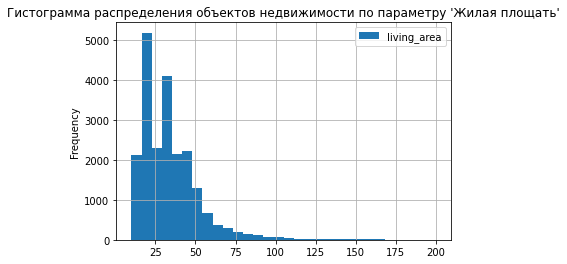

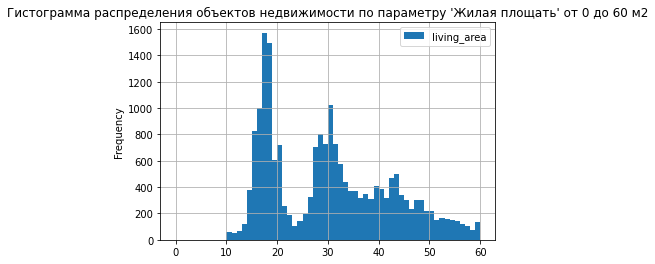

In [52]:
#Построим гистограммы
#data.hist('living_area', bins=30);
#data.hist('living_area', bins=60, range=(0,60));

data.plot(y = 'living_area', kind = 'hist', bins=30, grid=True, title="Гистограмма распределения объектов недвижимости по параметру 'Жилая площать'")
data.plot(y = 'living_area', kind = 'hist', bins=60, range=(0,60), grid=True, title="Гистограмма распределения объектов недвижимости по параметру 'Жилая площать' от 0 до 60 м2")

plt.show()

`floor` - этаж. Здесь нет нулевых значений и слишком больших значений.
Хочется сразу проверить есть ли значения этажа больше, чем этажность строения.

Этаж 0 0
Этаж 0 0
Этаж больше количества этажей:  0


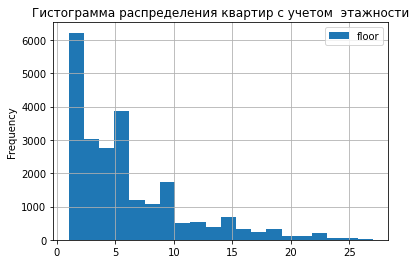

In [53]:
print('Этаж 0',data.query('floor == 0')['floor'].count())

print('Этаж 0',data.query('floor > 30')['floor'].count())

print('Этаж больше количества этажей: ',data.query('floor > floors_total')['floor'].count())

#data.hist('floor',bins=20);
data.plot(y = 'floor', kind = 'hist', bins=20, grid=True, title="Гистограмма распределения квартир с учетом  этажности")

plt.show()

`kitchen_area` - площадь кухни. 

In [54]:
print('Площадь кухни меньше 2 кв.м.: ',data.query('kitchen_area < 2')['living_area'].count())
print('Площадь кухни 5 кв.м.: ',data.query('kitchen_area == 5')['living_area'].count())
print('Площадь кухни больше 50 кв.м.: ',data.query('kitchen_area > 50')['living_area'].count())
print('Площадь кухни больше общей: ',data.query('kitchen_area > total_area')['living_area'].count())

Площадь кухни меньше 2 кв.м.:  1
Площадь кухни 5 кв.м.:  351
Площадь кухни больше 50 кв.м.:  33
Площадь кухни больше общей:  0


Здесь есть одна квартира с площадью кухни меньше 1 кв. метра. Явно аномалия.
Немало кухонь с площадью 5 кв.м. Кухонь с площадью более 30 кв.м. довольно мало.

Вывод - удалим строки с кухнами менее 2кв.м. и больше 50кв.м.

In [55]:
data.drop(index=data.query('kitchen_area < 2').index,inplace=True)
data.drop(index=data.query('kitchen_area > 50').index,inplace=True)

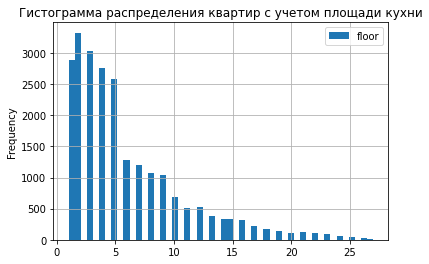

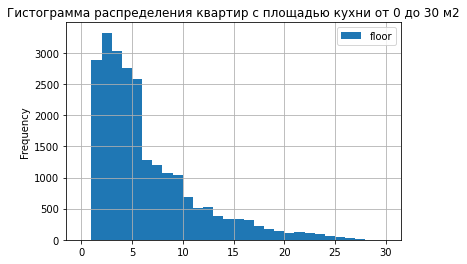

In [56]:
#data.hist('kitchen_area', bins=50);
#data.hist('kitchen_area', bins=30, range=(0,30));

data.plot(y = 'floor', kind = 'hist', bins=50, grid=True,  title="Гистограмма распределения квартир с учетом площади кухни")
data.plot(y = 'floor', kind = 'hist',  bins=30, range=(0,30), grid=True,  title="Гистограмма распределения квартир с площадью кухни от 0 до 30 м2")
plt.show()

`balcony` - количество балконов, всё выглядит хорошо.

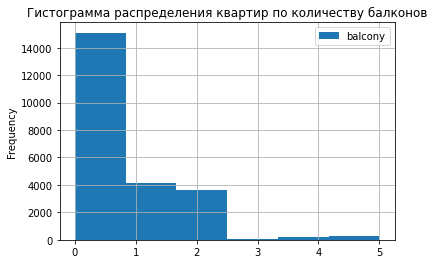

In [57]:
#data.hist('balcony', bins=6);
data.plot(y = 'balcony', kind = 'hist', bins=6, grid=True,  title="Гистограмма распределения квартир по количеству балконов")
plt.show()

`days_exposition` - сколько дней было размещено объявление 

In [58]:
print('Объявление не было оопубликовано: ',data.query('days_exposition == 0')['days_exposition'].count())

print('Объявлению больше 3 лет : ',data.query('days_exposition > 365*3')['days_exposition'].count())

Объявление не было оопубликовано:  3133
Объявлению больше 3 лет :  165


Видим, что очень много пустых значений и есть объявления, которые висели дольше 3-х лет отбросим их.

In [59]:
data.drop(index=data.query('days_exposition > 365*3').index,inplace=True)
data.drop(index=data.query('days_exposition == 0').index,inplace=True)

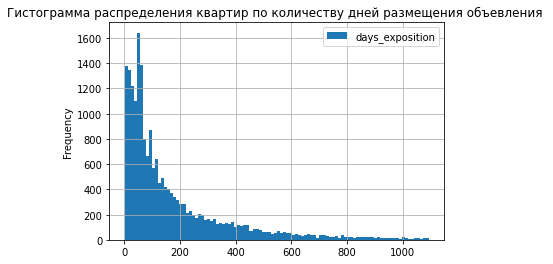

In [60]:
#data.hist('days_exposition', bins=100);
data.plot(y = 'days_exposition', kind = 'hist', bins=100, grid=True,  title="Гистограмма распределения квартир по количеству дней размещения объевления ")
plt.show()

Эти данные собраны автоматизированно. По гистограммам выглядят нормально. Выбивается одна строчка с airports_nearest. Квартир ближе 5 км к аэропорту одна, она похоже располагается в аэропорту. Её надо удалить. остальные данные нормальные.

* `airports_nearest`
* `city_centers_nearest`
* `parks_around3000`
* `parks_nearest`
* `ponds_around3000`
* `ponds_nearest`

Квартир слишком близко к аэропорту: 1


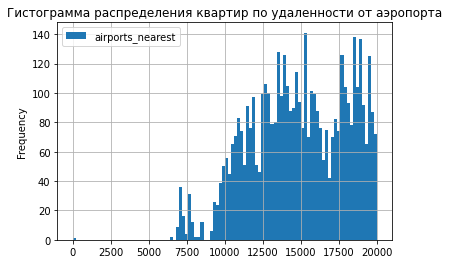

In [61]:
print('Квартир слишком близко к аэропорту:',data.query('airports_nearest < 5000')['airports_nearest'].count())

data.plot(y = 'airports_nearest', kind = 'hist', bins=100, range=(0,20000), grid=True, title="Гистограмма распределения квартир по удаленности от аэропорта")

plt.show()
data.drop(index=data.query('airports_nearest < 5000').index,inplace=True)

In [62]:
#Cбросим индексацию после удаления строк.
data.reset_index(drop=True,inplace=True)

Показатели о кол-ве объявлений в датасете, минимальных и максимальных показателях в выбранных параметрах о продаже квартир, сырые данные.

In [63]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"20,105.00","20,105.00","11,733.00","20,105.00","20,105.00","18,431.00","18,071.00","20,105.00","20,030.00"
min,0.00,12.00,2.50,1.00,"430,000.00",10.00,2.00,1.00,1.00
max,7.00,494.10,4.00,"1,095.00","98,000,000.00",200.00,50.00,27.00,29.00


In [64]:
data.rooms.value_counts().to_frame()

,rooms
1,7187
2,6803
3,4719
4,902
5,225
0,178
6,66
7,25


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20105 entries, 0 to 20104
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            20105 non-null  int64         
 1   last_price              20105 non-null  int64         
 2   total_area              20105 non-null  float64       
 3   first_day_exposition    20105 non-null  datetime64[ns]
 4   rooms                   20105 non-null  int64         
 5   ceiling_height          11733 non-null  float64       
 6   floors_total            20030 non-null  float64       
 7   living_area             18431 non-null  float64       
 8   floor                   20105 non-null  int64         
 9   is_apartment            20105 non-null  bool          
 10  studio                  20105 non-null  bool          
 11  open_plan               20105 non-null  bool          
 12  kitchen_area            18071 non-null  float6

Посмотрим сколько осталось данных от первоначального количества. Нам важно сохранить для исследования не менее 90% данных.

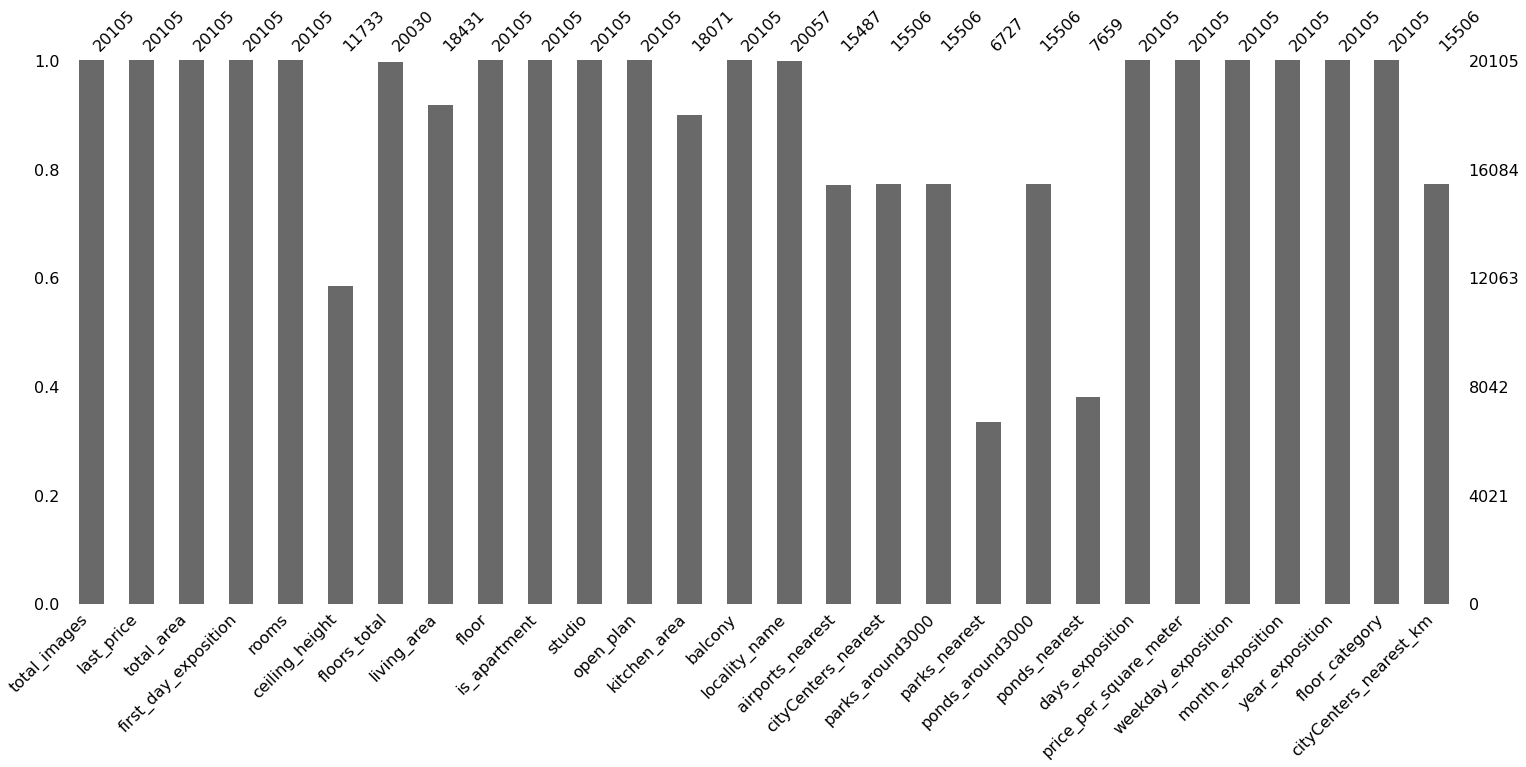

In [66]:
msno.bar(data)
plt.show()

Необходимый объем данных сохранен

####  Изучение параметры:
* общая площадь;
* жилая площадь;
* площадь кухни;
* цена объекта;
* количество комнат;
* высота потолков;
* тип этажа квартиры («первый», «последний», «другой»);
* общее количество этажей в доме;
* расстояние до центра города в метрах;
* расстояние до ближайшего парка

Для изучения данных параметров построим отдельные гистограммы и получим числовое описание данных.

In [67]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,cityCenters_nearest_km
count,20105.000000,2.010500e+04,20105.000000,20105.000000,11733.000000,20030.000000,18431.000000,20105.000000,18071.000000,20105.000000,15487.000000,15506.000000,15506.000000,6727.000000,15506.000000,7659.000000,20105.00000,20105.000000,20105.000000,20105.000000,20105.000000,15506.000000
mean,9.609998,5.822429e+06,57.586406,2.002189,2.711214,10.867499,32.824071,5.986869,10.233809,0.592191,28880.350294,14360.488843,0.593061,490.384124,0.749452,523.846716,171.42855,96746.119788,2.589207,6.585775,2017.236309,14.354443
std,5.652056,5.458617e+06,28.622170,0.995711,0.243575,6.599664,18.312911,4.926603,4.847674,0.948258,12750.212555,8521.147399,0.791368,342.832227,0.922667,276.476805,197.24259,39295.840403,1.784225,3.481764,0.945813,8.528776
min,0.000000,4.300000e+05,12.000000,0.000000,2.500000,1.000000,10.000000,1.000000,2.000000,0.000000,6450.000000,208.000000,0.000000,1.000000,0.000000,13.000000,1.00000,7962.960000,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000e+06,39.400000,1.000000,2.520000,5.000000,18.200000,2.000000,7.000000,0.000000,18446.000000,9626.000000,0.000000,287.000000,0.000000,303.500000,44.00000,76342.280000,1.000000,3.000000,2017.000000,10.000000
50%,9.000000,4.500000e+06,50.400000,2.000000,2.650000,9.000000,29.900000,4.000000,9.000000,0.000000,26902.000000,13220.500000,0.000000,451.000000,0.000000,509.000000,93.00000,93750.000000,3.000000,7.000000,2017.000000,13.000000
75%,14.000000,6.450000e+06,67.000000,3.000000,2.800000,16.000000,41.000000,8.000000,11.700000,1.000000,37412.000000,16408.000000,1.000000,614.000000,1.000000,733.000000,224.00000,111764.710000,4.000000,10.000000,2018.000000,16.000000
max,50.000000,9.800000e+07,494.100000,7.000000,4.000000,29.000000,200.000000,27.000000,50.000000,5.000000,84006.000000,65105.000000,3.000000,3190.000000,3.000000,1344.000000,1095.00000,719298.250000,6.000000,12.000000,2019.000000,65.000000


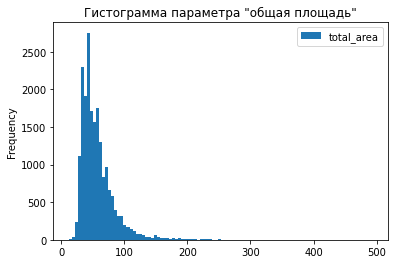

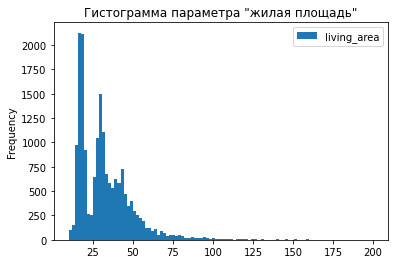

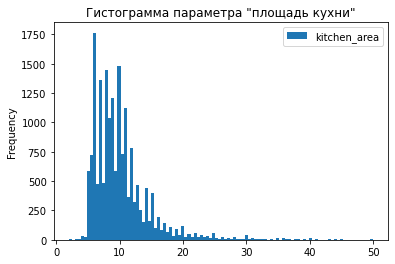

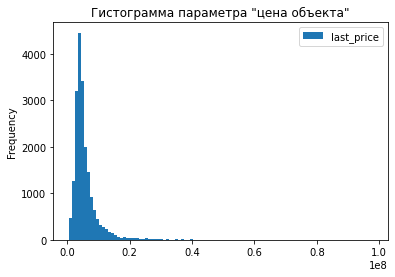

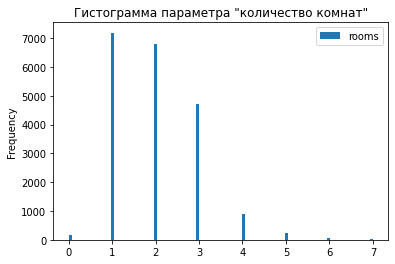

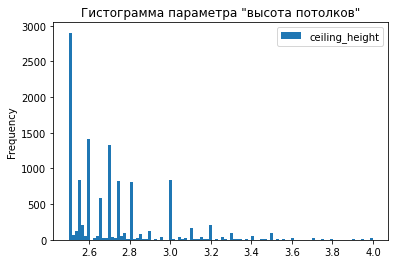

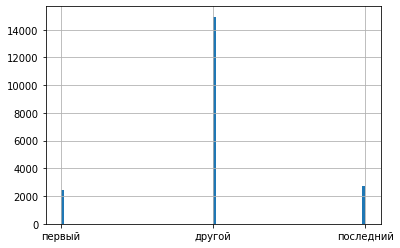

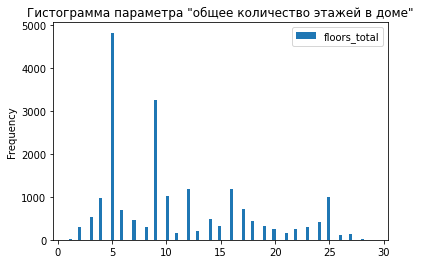

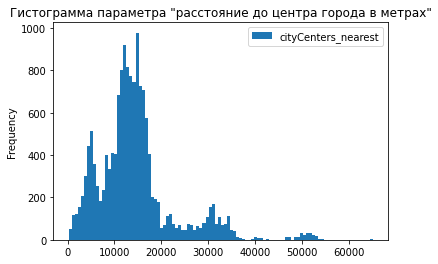

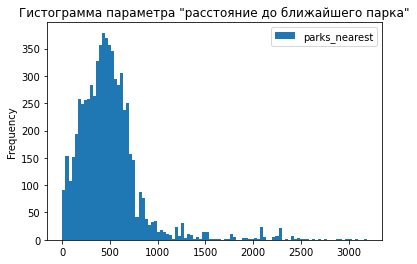

In [68]:
#посмотрим данные в  данных столбцах

param_description =  {'total_area':'общая площадь',
                   'living_area':'жилая площадь',
                    'kitchen_area':'площадь кухни',
                    'last_price':'цена объекта',
                    'rooms':'количество комнат',
                    'ceiling_height':'высота потолков',
                    'floor_category':'тип этажа квартиры',
                    'floors_total':'общее количество этажей в доме',
                    'cityCenters_nearest':'расстояние до центра города в метрах',
                    'parks_nearest':'расстояние до ближайшего парка'
                   } 

for par, description in param_description.items(): 
    try:
        data.plot(title=f'Гистограмма параметра "{description}"', y = par, kind = 'hist',bins = 100)
    except:  
        data[par].hist(bins=100)
    plt.show()
    print()

**Выводы** 

1. Общая площадь в нашей выборке имеет среднее значение 57,59, а медиана 50.4 м2. Распределение данных соответствует нормальному распределению. Наблюдаем очень малое количество квартир с общей площадью более 150 кв.м. Имеются выбросы, но это просто элитная недвижимость.

2. Жилая площадь в выборке имеет среднее значение 32.82, а медиана 30.0 м2. Распределение данных соответствует нормальному распределению. Есть выбросы, но они не сильно влияют на данные. Гистограмма жилой площади имеет два ярко выраженных пика: наиболее сильный в районе 18-19 м2 и более слабый 30 - 31 м2. Скорее всего они соответствуют жилой площади стандартных однокомнатных и двухкомнатных квартир. 

3. Площадь кухни в выборке кимеет среднее значение 10.57 , а медиана 9,1 м2. Распределение данных соответствует нормальному распределению.

4. Цены на недвижимость имеют среднее значение в 5,8 млн руб., медиана 4,5 млн руб. Распределение данных соответствует нормальному распределению.

5. Параметр Количество комнат в выборке имеет среднее значение равное медиане = 2.  Больше всего однокомнатных квартир, чуть меньше продают двухкомнатные квартиры.

6. Высота потолков в среднем составляет 2,7 м, медиана 2,65 м. Здесь два пика 2.5м и 3м, что логично.

7. По типу этажа кватриры видим, что на продажи квартир на первом и последнем этажах примерно одинаковые, но на последнем этаже квартиры продают все же чуть-чуть чаще. Больше всего квартир на "другом" этаже и это логично.

8. Количество этажей в выборке в среднем соответствует  10.86, а медиана 9. Распределение данных соответствует нормальному распределению. Больше всего продают квартиры в 5 этажаных домах,  поменьше , но все же так же арко выражены продажи в 9 квартирных домах. Скорее всего это связано с популярностью данной этажности для МЖД. Так же имеются небольшие пики более высоких новостроек.

9. Расстояние до центра города в метрах имеют среднее значение 14360.5, а медиана 13220.5. Здесь наблюдаем два пика, один маленький, 5км и другой побльшой от 10 км. до 15 км. Так же есть совсем небольшие всплески на 30 км. и 50 км.

9. Расстояние до ближайшего парка  в среднем соответствует значению значение 490.4, а медиана 451.0. Распределение данных соответствует нормальному распределению. Судя по графику больше всего квартир с парками на расстоянии до 750м.

#### Изучите время продажи квартиры  

Столбец `days_exposition`. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

In [69]:
# c помощью метода describe() посмотрим на числовое описание данных
data['days_exposition'].describe()

count    20105.00000
mean       171.42855
std        197.24259
min          1.00000
25%         44.00000
50%         93.00000
75%        224.00000
max       1095.00000
Name: days_exposition, dtype: float64

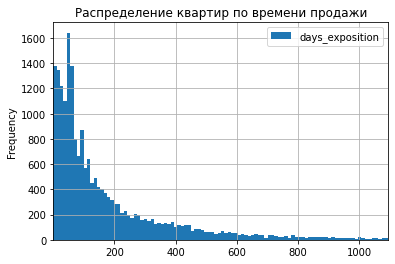

In [70]:
# построим гистограмму
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,1095), xlim=(1,1095), title='Распределение квартир по времени продажи')
plt.show()

По гистограмме видим, что распределение данных соответствует распределению Пуассона

In [71]:
#Взглянем на диаграмму размаха 
plt.boxplot(data['days_exposition']")
plt.ylim(1,1095)

SyntaxError: EOL while scanning string literal (1572233710.py, line 2)

По диаграмме размаха видим что в данных очень много выбросов, которые могут влиять на среднее и медиану. Избавимся от и выбросов и снова посмотрим на данные.

In [ ]:
# Построим гистограмму в диапазоне от 1 до 500
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,500), xlim=(1,500), title="Распределение квартир для времени продажи от 1 до 500 дней" )
plt.show()        

In [ ]:
#посмотрим на среднее значение, медиана и межквартильный размах для данных <500
data[data['days_exposition']<500]['days_exposition'].describe()

Можно заметить, что значения стали наиболее правдопадобными.

In [ ]:
# Посмотрим на гистограмму со значениями от 1 до 200 с кол-вом корзин 100
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200), title="Распределение квартир для времени продажи от 1 до 200 дней")
plt.show()

In [ ]:
# С помощью метода value_counts() оценим наиболле  частое время продаж в днях 
data[data['days_exposition']!=0]['days_exposition'].value_counts()

Обратим внимание, что много объявлений о продаже закрывается через 45 дней, возможно это несвязано с датой продажи.

Изучим правила размещения объявлений в Яндекс Недвижимость https://yandex.ru/support/realty/owner/home/add-ads-housing.html.
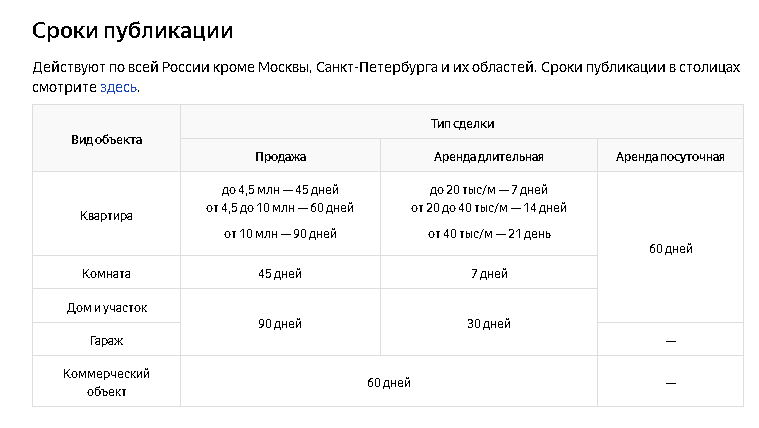

Оказалось, что именно после этих сроков объявление считается неактуальным и снимается автоматически.  

**Вывод:** судя по гистограмме - мы имеем распределение Пуассона. Среднее значение - 180 дней, а медиана - 95 дней.
Сделав гистограмму со значениями от 1 до 200 с кол-вом корзин 100, обнаружили выбивающиеся значения и методом value_counts убедились в этом - у нас аномалии на 45, 60, 7, 30, 90 днях - это наиболее популярное количество дней до снятия объявления.

После изучения правил размещения объявлений в Яндекс Недвижимость, оказалось что именно после этих сроков объявление считается неактуальным и снимается автоматически.

Наверное, нам нужно убрать эти значения из выборки, но нужно подумать есть ли еще критерии для снятия таких объявлений, ведь часть из таких квартир могла и правда продаться в этот срок.


In [ ]:
# Посмотрим на все данные по объектам, для которых срок снятия объевления с продажи == 45
data[data['days_exposition']==45] 

**Вывод:** никаких общих особенностей в обьявлениях, снятых через 45 дней не выявлено, потому будем убирать эти данные из наших расчетов, как и данные с 60, 90 и 7 дней в столбце days_exposition, так как это аномалии.

До того, как мы очистим наши данные от аномалий, нам нужно дать ответ на вопрос, какое количество дней считать нормальным, а какое выбросом на текущий момент до очистки данных.
Исходя из метода describe, межквартильный размах - от 45 до 232 дней, исходя же из метода boxplot - диаграмма размаха у нас от минимального значения до примерно 500 дней. Значит необоснованно быстрых значений у нас нет, а необоснованно долгие - от 500 дней и выше. Значит нормальные значения у нас лежат от 1 до 500.

На текущий момент мы уже знаем, что эти данные неправильные, но они нам нужны, чтобы сравнить с данными, очищенными от аномалий далее.

Но удалением данных, обязательно нужно уточнить у сотрудников насчет выбивающихся значений по датам снятия объявлений, чтобы убедиться в том, какие данные необходимо исключить из выборки.

In [72]:
#отфильтруем данные от аномалий и запишем их в data
data = data.query('days_exposition not in [45, 60, 90, 7, 0]')
data.head(15)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenters_nearest_km
0,7,3350000,40.40,2018-12-04,1,NaN,11.0,18.60,1,False,False,False,11.00,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,82920.79,1,12,2018,первый,19.0
1,10,5196000,56.00,2015-08-20,2,NaN,5.0,34.30,4,False,False,False,8.30,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,92785.71,3,8,2015,другой,14.0
2,0,64900000,159.00,2015-07-24,3,NaN,14.0,NaN,9,False,False,False,NaN,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,408176.10,4,7,2015,другой,7.0
3,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,False,False,41.00,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,100000.00,1,6,2018,другой,8.0
4,10,2890000,30.40,2018-09-10,1,NaN,12.0,14.40,5,False,False,False,9.10,0,поселок городского типа янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55,95065.79,0,9,2018,другой,NaN
5,6,3700000,37.30,2017-11-02,1,NaN,26.0,10.60,6,False,False,False,14.40,1,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155,99195.71,3,11,2017,другой,19.0
6,20,2900000,33.16,2018-05-23,1,NaN,27.0,15.43,26,False,False,False,8.81,0,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,189,87454.76,2,5,2018,другой,NaN
7,18,5400000,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,False,False,6.50,2,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289,88524.59,6,2,2017,другой,15.0
8,5,5050000,39.60,2017-11-16,1,2.67,12.0,20.30,3,False,False,False,8.50,0,санкт-петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137,127525.25,3,11,2017,другой,14.0
11,20,3550000,42.80,2017-07-01,2,2.56,5.0,27.00,5,False,False,False,5.20,1,петергоф,37868.0,33058.0,1.0,294.0,3.0,298.0,366,82943.93,5,7,2017,последний,33.0


(1.0, 1000.0)

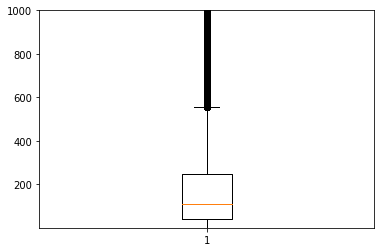

In [73]:
# посмотрим на диаграмму размаха
plt.boxplot(data['days_exposition'])
plt.ylim(1,1000)

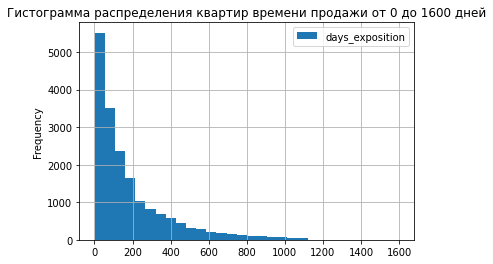

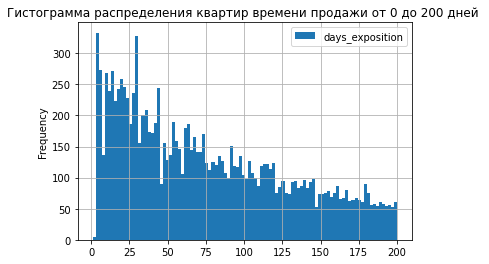

In [74]:
#оценим гистограммы
data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600), title='Гистограмма распределения квартир времени продажи от 0 до 1600 дней')
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200), title='Гистограмма распределения квартир времени продажи от 0 до 200 дней ')
plt.show()

In [75]:
#Посмотрим среднее значение, медиана и межквартильный размах в очищенных данных
data['days_exposition'].describe()

count    18268.000000
mean       183.683545
std        202.800841
min          1.000000
25%         42.000000
50%        110.000000
75%        247.000000
max       1095.000000
Name: days_exposition, dtype: float64

**Вывод:** ожидаемо, в очищенных данных от аномалий и нулевых значений получаем бОльшие значения медианы и среднего значения - 114 и 195 соответственно, вместо 95 и 180. Аналогично, теперь нормальные значения располагаются от 1 до 600 дней вместо от 1 до 500 дней.

####  Какие факторы больше всего влияют на стоимость квартиры? 
Изучите, зависит ли цена квадратного метра от общей площади квартиры, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года.

In [76]:
list_for_graph = ['total_area',
                  'living_area',
                  'kitchen_area',
                  'rooms',
                  'floors_total',
                  'weekday_exposition',
                  'month_exposition',
                  'year_exposition']

for entry in list_for_graph:
    correlation = data['last_price'].corr(data[entry])
    print(f'Корреляция между last_price и {entry} составляет: {correlation:0.2%}')

Корреляция между last_price и total_area составляет: 75.10%
Корреляция между last_price и living_area составляет: 65.66%
Корреляция между last_price и kitchen_area составляет: 54.40%
Корреляция между last_price и rooms составляет: 46.11%
Корреляция между last_price и floors_total составляет: 2.14%
Корреляция между last_price и weekday_exposition составляет: 0.02%
Корреляция между last_price и month_exposition составляет: 0.32%
Корреляция между last_price и year_exposition составляет: -6.56%


Построим графики

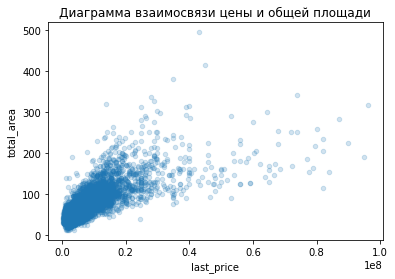

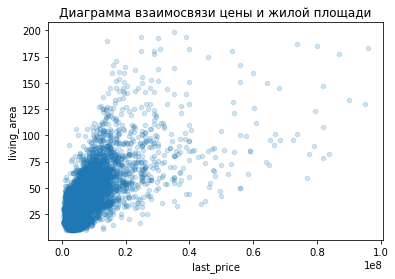

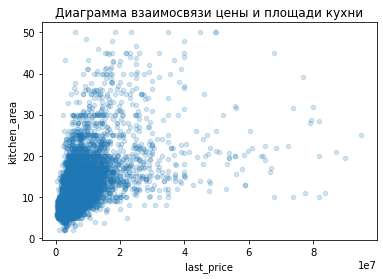

In [77]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.2, title='Диаграмма взаимосвязи цены и общей площади')
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.2, title='Диаграмма взаимосвязи цены и жилой площади')
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.2, title='Диаграмма взаимосвязи цены и площади кухни')
plt.show()

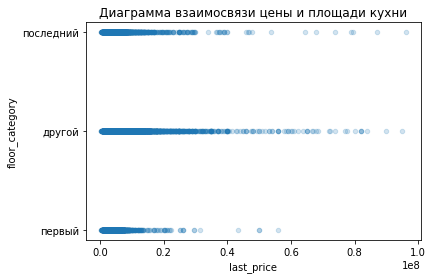

In [78]:
data.plot(x='last_price', y='floor_category', kind='scatter', alpha=0.2, title='Диаграмма взаимосвязи цены и площади кухни')
plt.show()

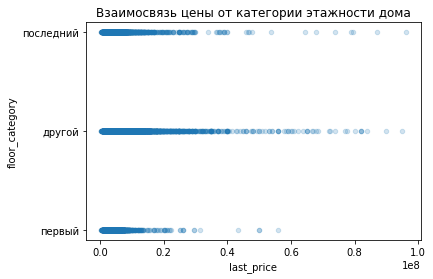

In [79]:
data.plot(x='last_price', y='floor_category', kind='scatter', alpha=0.2,   title='Взаимосвязь цены от категории этажности дома')
plt.show()

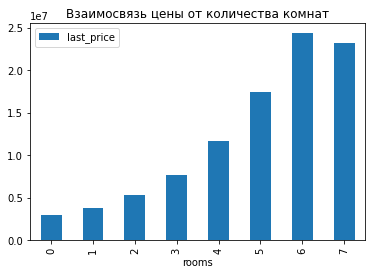

In [80]:
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar',  title='Взаимосвязь цены от количества комнат');

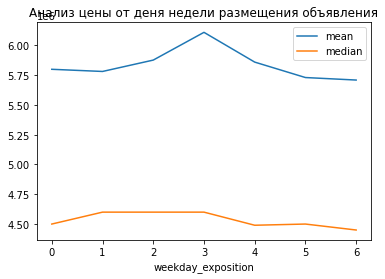

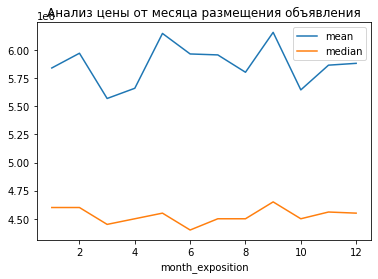

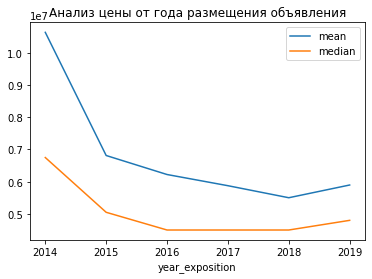

In [92]:
ax= data.pivot_table(index='weekday_exposition',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', label='mean');
data.pivot_table(index='weekday_exposition',values='last_price',aggfunc='median').plot(y='last_price', kind='line', ax = ax,  label='median', title='Анализ цены от деня недели размещения объявления');


ax= data.pivot_table(index='month_exposition',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', label='mean');
data.pivot_table(index='month_exposition',values='last_price',aggfunc='median').plot(y='last_price', kind='line', ax = ax,  label='median', title='Анализ цены от месяца размещения объявления');


ax= data.pivot_table(index='year_exposition',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', label='mean');
data.pivot_table(index='year_exposition',values='last_price',aggfunc='median').plot(y='last_price', kind='line', ax = ax,  label='median', title='Анализ цены от года размещения объявления');

Цена по убыванию зависит от:
* общей площади;
* жилой площади;
* площади кухни;
* количества комнат.

Цена практически на зависит от:
* этажа, на котором расположена квартира;
* даты размещения.

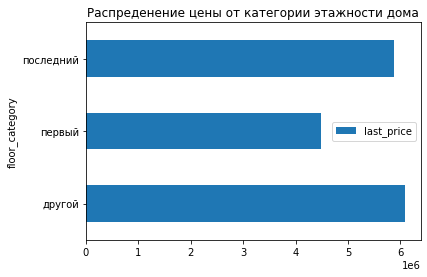

In [93]:
data.pivot_table(index='floor_category',values='last_price').plot(y='last_price', kind='barh',   title='Распреденение цены от категории этажности дома')
plt.show()


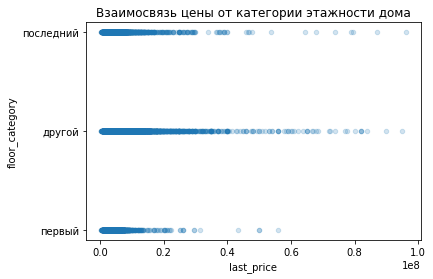

In [94]:
data.plot(x='last_price', y='floor_category', kind='scatter', alpha=0.2,   title='Взаимосвязь цены от категории этажности дома')
plt.show()

#### Cредняя цена одного квадратного метра в топ-10 населенных пунктах

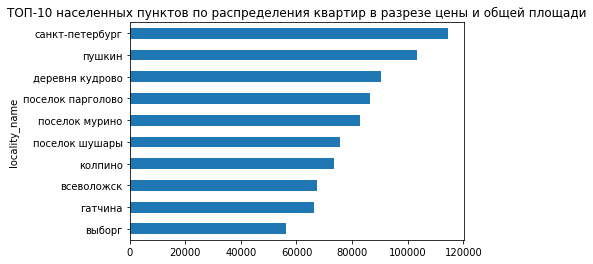

In [95]:
top_10 = data.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])
top_10.columns=['last_price_sum','total_area_sum','last_price_count','total_area_count']
top_10.pop('total_area_count')
top_10.sort_values(by=['last_price_count'],ascending=False, inplace=True)
top_10 = top_10.iloc[:10]
top_10['price_per_sq_m'] = top_10['last_price_sum']/top_10['total_area_sum']
top_10.sort_values(by=['price_per_sq_m'],ascending=True, inplace=True)
top_10['price_per_sq_m'].plot(kind='barh',   title='ТОП-10 населенных пунктов по распределения квартир в разрезе цены и общей площади')
plt.show()

In [96]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenters_nearest_km
0,7,3350000,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,False,False,11.0,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,82920.79,1,12,2018,первый,19.0
1,10,5196000,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,92785.71,3,8,2015,другой,14.0
2,0,64900000,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,False,False,NaN,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,408176.10,4,7,2015,другой,7.0
3,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,100000.00,1,6,2018,другой,8.0
4,10,2890000,30.4,2018-09-10,1,NaN,12.0,14.4,5,False,False,False,9.1,0,поселок городского типа янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55,95065.79,0,9,2018,другой,NaN


In [97]:
data['rooms'].value_counts()

1    6515
2    6154
3    4309
4     841
5     208
0     157
6      61
7      23
Name: rooms, dtype: int64

In [98]:
data.groupby(by='rooms')['rooms'].count().sort_values(ascending=False)

rooms
1    6515
2    6154
3    4309
4     841
5     208
0     157
6      61
7      23
Name: rooms, dtype: int64

Ожидаемо самая дорогая недвижимость в Санкт-Петербурге.
В ТОП-10 входят ближайшие к Санкт-Петербургу города.

#### Расстояние до центра города

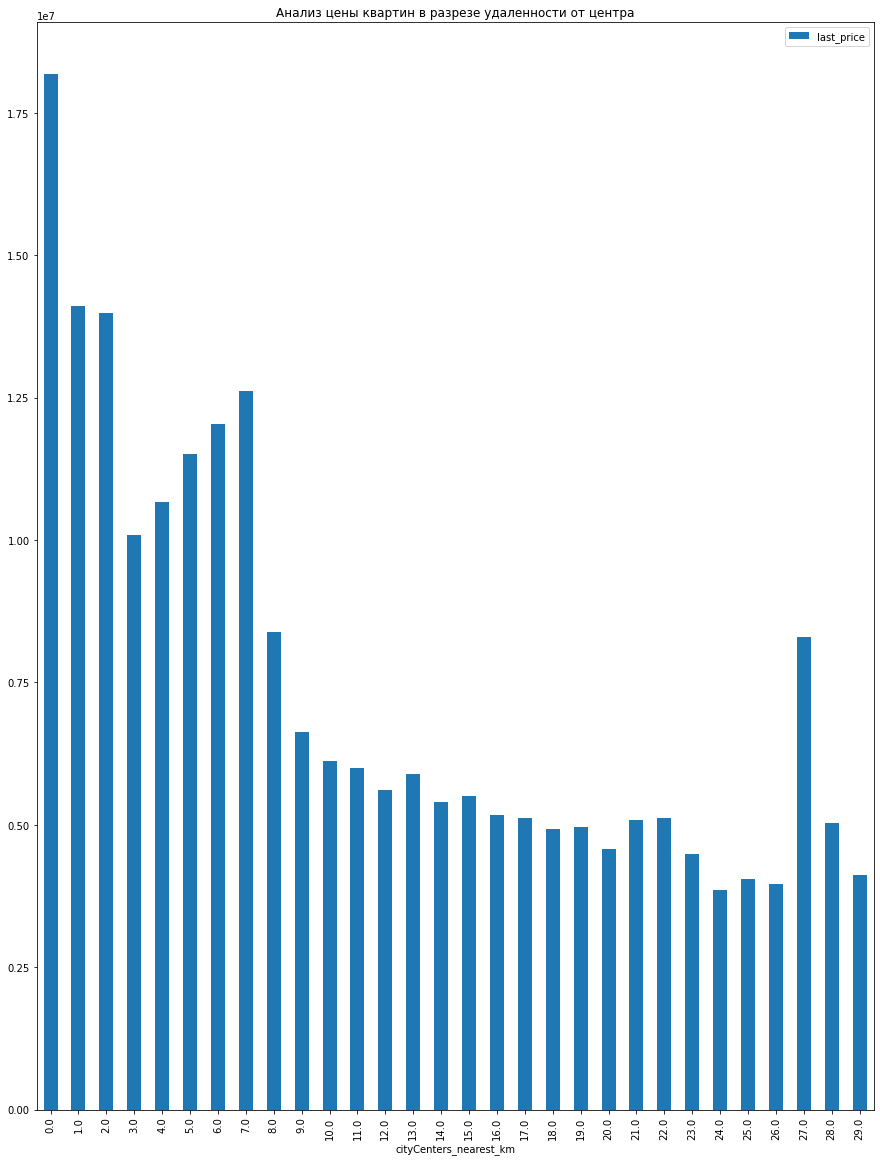

In [99]:
(    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index=['cityCenters_nearest_km' ],
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar', title='Анализ цены квартин в разрезе удаленности от центра', figsize=(15, 20))
)

plt.show()


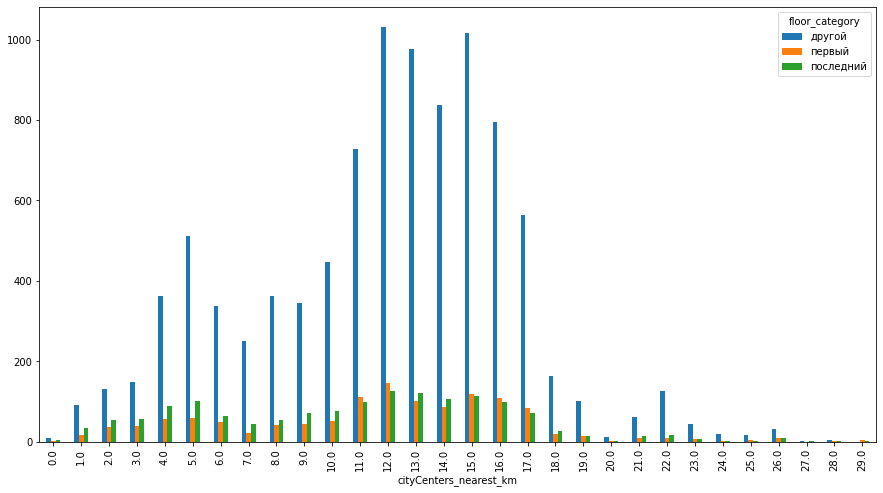

In [100]:
df = data[data['locality_name']=='санкт-петербург'].groupby(['cityCenters_nearest_km','floor_category' ])['floor_category'].count()
df.unstack().plot(kind='bar', stacked=False,  figsize = (15, 8))
plt.show()

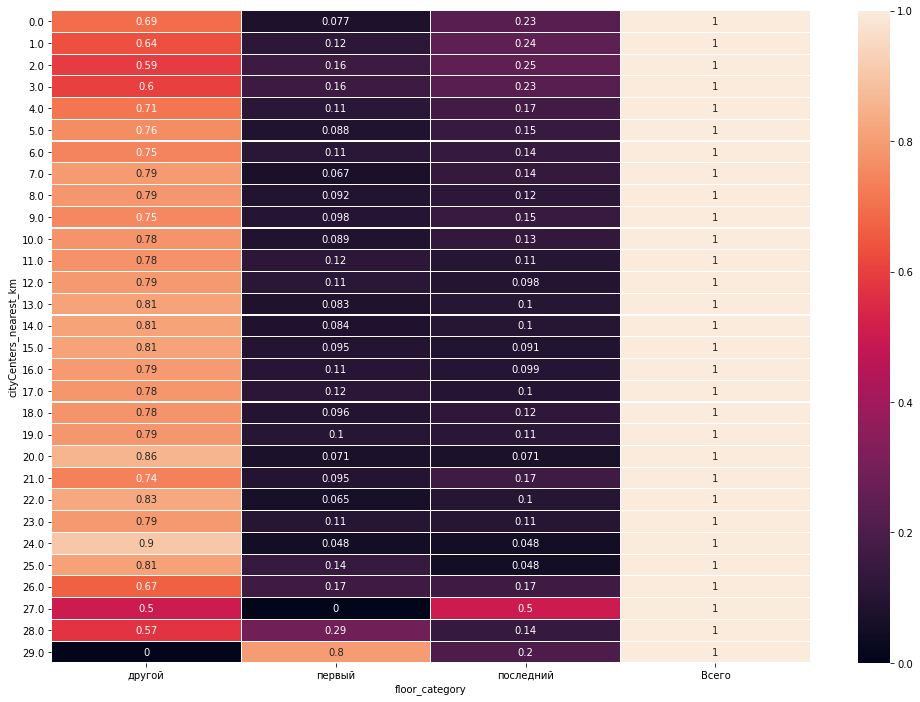

In [101]:

g='санкт-петербург'
data_pivot = data.query('locality_name == @g').pivot_table(index = ['cityCenters_nearest_km'],columns = 'floor_category' ,values = 'floor', aggfunc = 'count').fillna(0).astype(int)    
data_pivot['Всего'] = data_pivot[['другой', 'первый', 'последний']].sum(1)
#for i in ['другой', 'первый', 'последний']:
#    data_pivot[f'доля категории "{i}"']=data_pivot[i]/data_pivot['Всего']
#data_pivot[['другой','доля категории "другой"', 'первый', 'доля категории "первый"', 'последний','доля категории "последний"','Всего']]
for i in data_pivot.columns:
    data_pivot[i]=data_pivot[i]/data_pivot['Всего']
ax =  plt.subplots( figsize = (17, 12))
ax = sb.heatmap(data_pivot, linewidths=.1, annot=True ) 

С большим отрывом лидирует недвижимость до 1км.
Видим более низкие цены на недвижимость на расстоянии от 1 км. до 7 км. включительно.
Далее цена спадает на расстоянии от 8 км. до 27 км.
Видим пик на 27км, его сложно объяснить, возможно это недвижимость в "особом" районе.

,count,median
year_exposition,,
2014,85,6750000
2015,972,5050000
2016,2554,4500000
2017,7204,4500000
2018,6500,4500000
2019,953,4800000


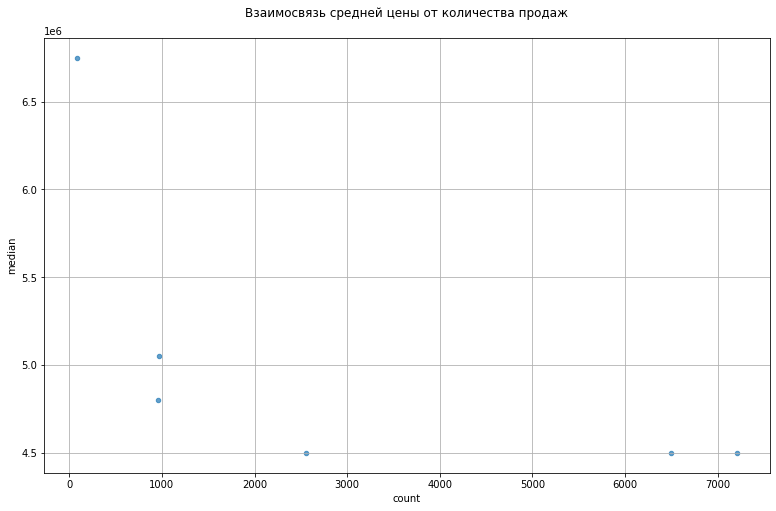

Коэффициент корреляции между средней стоимостью и количеством обьявлений: -0.6267636169216634


In [119]:
table_svod=data.pivot_table(index='year_exposition',values='last_price',aggfunc=('count','median'))
display(table_svod)
(table_svod.plot(x='count', y='median', kind='scatter', style='0', grid=True, figsize=(13,8),
       alpha=0.7,   title='Взаимосвязь средней цены от количества продаж\n')
)
plt.show()
print("Коэффициент корреляции между средней стоимостью и количеством обьявлений:", table_svod['count'].corr(table_svod['median']))

Наблюдается слабая отрицательная корреляция между количеством объявлений и средней стоимостью квартир. То есть если есть рост одной величины то другая величина уменьшается и наоборот.

### Общий вывод
После изучения данных можно сказать, что можно работать с таблицами, в которых встречаются пропущенные значения. Данные всё-таки лучше очищать от явных "выбросов", но возможно чистить данные придётся после этапа исследовательского анализа данных. В нашем примере - это дорогие квартиры, которые портили корреляции и графики зависимости полной стоимости от разных параметров. Из необычных особенностей:

1. В 27 км от центра Санкт-Петербурга есть недвижимость по цене почти равная недвижимости в 8 км. от центра;
2. В ТОП-10 входят в основном ближайшие к Санкт-Петербургу города и самые крупные города области:
    * Пушкин;
    * Гатчина;
    * Всеволожск;
    * Выборг.
3. Цена в основном зависит от площади квартиры, но корреляция с этажностью(не первый и не последний) видна на графике.
4. Таких квартир явно больше и они явно дороже.
5. Быстрые продажи это до 95 дней, а необычно долгие - свыше 181 дня.\
6. Выбросы Количество объявлений, которые сняты через срез:
    * 45 дней: 872
    * 60 дней: 536
    * 7 дней: 230    
    * 90 дней: 204